In [4]:
# !git clone https://github.com/fastai/course-v3
%cd /content/course-v3/nbs/dl2
%load_ext autoreload
%autoreload 2
%matplotlib inline
from exp.nb_06 import *

def get_data():
    path = Path('/content/mnist.pkl.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]
nfs = [8, 16, 32, 64, 64]
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

%time run.fit(2, learn)

/content/course-v3/nbs/dl2
train: [1.1259634375, tensor(0.6354, device='cuda:0')]
valid: [0.1831650390625, tensor(0.9414, device='cuda:0')]
train: [0.2151898828125, tensor(0.9358, device='cuda:0')]
valid: [0.1320376708984375, tensor(0.9605, device='cuda:0')]
CPU times: user 3.83 s, sys: 904 ms, total: 4.73 s
Wall time: 4.65 s


In [7]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
[(i, getattr(learn.opt.param_groups[-1], i)) for i in dir(learn.opt.param_groups[-1]) if i.startswith('__')]

[('__class__', dict),
 ('__contains__', <function dict.__contains__>),
 ('__delattr__',
  <method-wrapper '__delattr__' of dict object at 0x7f3c7a321820>),
 ('__delitem__',
  <method-wrapper '__delitem__' of dict object at 0x7f3c7a321820>),
 ('__dir__', <function dict.__dir__>),
 ('__doc__',
  "dict() -> new empty dictionary\ndict(mapping) -> new dictionary initialized from a mapping object's\n    (key, value) pairs\ndict(iterable) -> new dictionary initialized as if via:\n    d = {}\n    for k, v in iterable:\n        d[k] = v\ndict(**kwargs) -> new dictionary initialized with the name=value pairs\n    in the keyword argument list.  For example:  dict(one=1, two=2)"),
 ('__eq__', <method-wrapper '__eq__' of dict object at 0x7f3c7a321820>),
 ('__format__', <function dict.__format__>),
 ('__ge__', <method-wrapper '__ge__' of dict object at 0x7f3c7a321820>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of dict object at 0x7f3c7a321820>),
 ('__getitem__', <function dict.__ge

In [22]:
learn.opt.param_groups[-1].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])

In [26]:
run.in_train

False

In [23]:
class Recorder(Callback):
    def begin_fit(self):
        self.lrs, self.losses = [], []
    
    def after_batch(self):
        if not self.in_train: return
        self.lrs.apppend(self.opt.param_groups[-1]['lr'])
        self.losses.apppend(self.loss.detach().cpu())
    
    def plot_lr(self): plt.plot(self.lrs)

    def plot_loss(self): plt.plot(self.losses)

In [27]:
class ParamScheduler(Callback):
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)

    def begin_batch(self):
        if not self.in_train: return
        self.set_param()

In [24]:
??CudaCallback

In [22]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [23]:
@annealer
def sched_lin(start, end, pos):
    return start + pos * (end-start)

In [24]:
@annealer
def sched_exp(start, end, pos):
    return start * (end / start) ** pos

In [25]:
@annealer
def sched_cos(start, end, pos):
    return start + ( 1+ math.cos(math.pi*(1-pos))) * (end-start) / 2

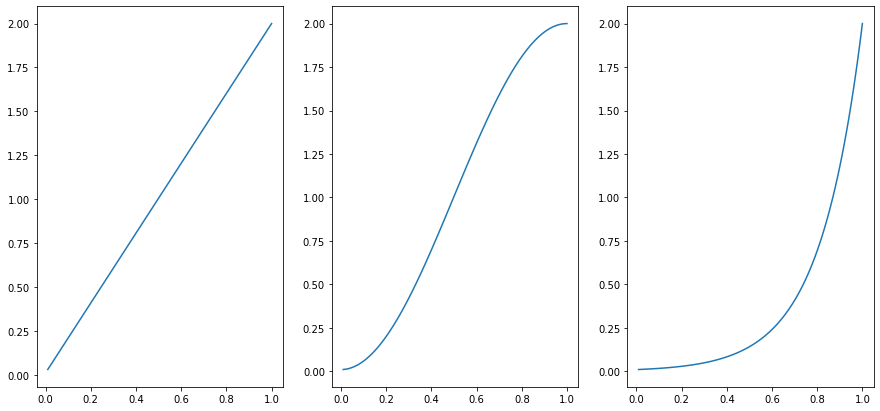

In [34]:
schedulers = [sched_lin, sched_cos, sched_exp]

fig, axes = plt.subplots(1, 3, figsize=(15,7))
for ax, sched_fn in zip(axes, schedulers):
    poses = torch.linspace(0.01, 1, 100)
    f = sched_fn(1e-2, 2)
    ax.plot(poses, [f(point) for point in poses])

In [35]:
!pip install -qq ipdb
import ipdb

In [44]:
def combine_sched(percentages, schedulers):
    assert sum(percentages) == 1.
    pctgs = torch.tensor([0] + percentages)
    assert all(percentages) > 0.
    pctgs = torch.cumsum(pctgs, dim=0)
    def _inner(pos):
        # pick up sched function index corresponded to positioned percentage
        # ipdb.set_trace()
        idx = (pctgs < pos).nonzero().max()
        if idx == len(pctgs): idx -= 1
        act_pos = (pos - pctgs[idx]) / (pctgs[idx+1]- pctgs[idx])
        # print(idx, act_pos, schedulers[idx])
        return schedulers[idx](act_pos)
        # return idx
    return _inner

In [45]:
scheds = [sched_lin(0.01, 0.1), sched_cos(0.1, 0.9), sched_cos(0.9, 0.3)]
f = combine_sched([0.1, 0.3, 0.6], scheds)

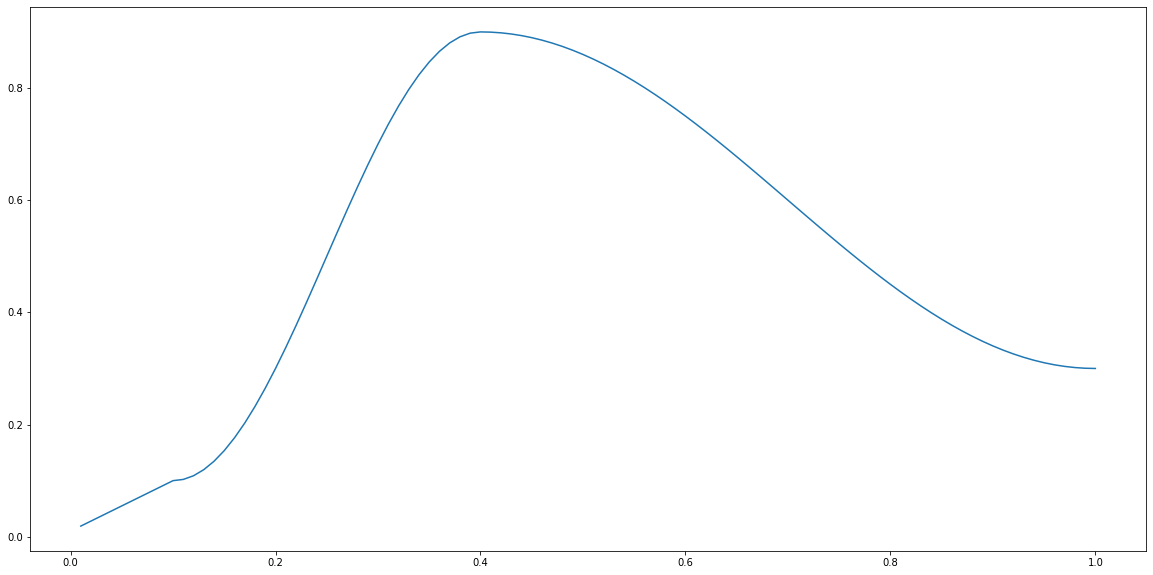

In [52]:
plt.figure(figsize=(20,10))
points = torch.linspace(0.01, 1, 100)
plt.plot(points , [f(o) for o in points])